
      CALCUL BAYESIEN POUR UN MODELE HIERARCHIQUE BETA - BINOMIAL

       Utilisation de PyMC3



                  Donnees X  ~ Loi BINOMIALE (N,p). 

                  Prior (niveau 1) sur p = THETA = Loi BETA (a,b)
                  Prior (niveau 2) sur a = dgamma(0.0001,0.0001)
                  b = 9 * a   






In [5]:
import arviz as az                    # fonctions utiles pour l'analyse exploratoire de modèles bayésiens
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm                    # routines de calcul bayésien
import pymc3.distributions.transforms as tr
import seaborn as sns                 # routines de visualisation
import theano.tensor as tt            # manipulation efficaces de structures de données (ex : tableaux multidim)


%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")


print(f"Running on PyMC3 v{pm.__version__}")  # Il est utile de penser à placer cette ligne

Running on PyMC3 v3.11.1


In [6]:
# Données
x = np.array([7, 7, 5, 8, 3, 4, 6, 4, 5, 4, 4, 4, 6, 3, 5, 1, 5, 7, 7, 3])
n = len(x)

In [7]:
beta_binomial_model = pm.Model()  # crée un modèle bayésien

with beta_binomial_model:    # crée un 'context manager', 
    
    # Loi a priori gamma pour a (niveau 2)
    a = pm.Gamma("a",alpha=1,beta=1)
    b = 9.0*a #pm.Deterministic("b",9.0*a)
    
    # Loi a priori beta pour theta (niveau 1)
    theta = pm.Beta("theta", alpha=a, beta=b)

    # Vraisemblance X ~ theta
    p = pm.Binomial("x", p=theta, observed=x, n=n)
    
    #-----------
    # Remarque :
    #-----------
    # Pour des variables binaires, il faut utiliser pm.BinaryMetropolis
    # Pour des variables discrètes, des classes pm.Metropolis existents dans PyMC3
    # voir : https://docs.pymc.io/api/inference.html
    

    # Echantillonnage
    trace = pm.sample(10000, tune=2000, target_accept=0.95,chains=3)
    
    # Le sampleur générique "pm.sample" va utiliser une routine NUTS (No U-Turn Sampling) qui implémente
    # un algorithme MCMC hamiltonien récent réservé aux variables continues
    
    
    
    # Traçons les résultats 
    #az.plot_trace(trace,var_names=["a", "theta"])

/Users/nicolasbousquet/opt/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta, a]


Sampling 3 chains for 2_000 tune and 10_000 draw iterations (6_000 + 30_000 draws total) took 82 seconds.


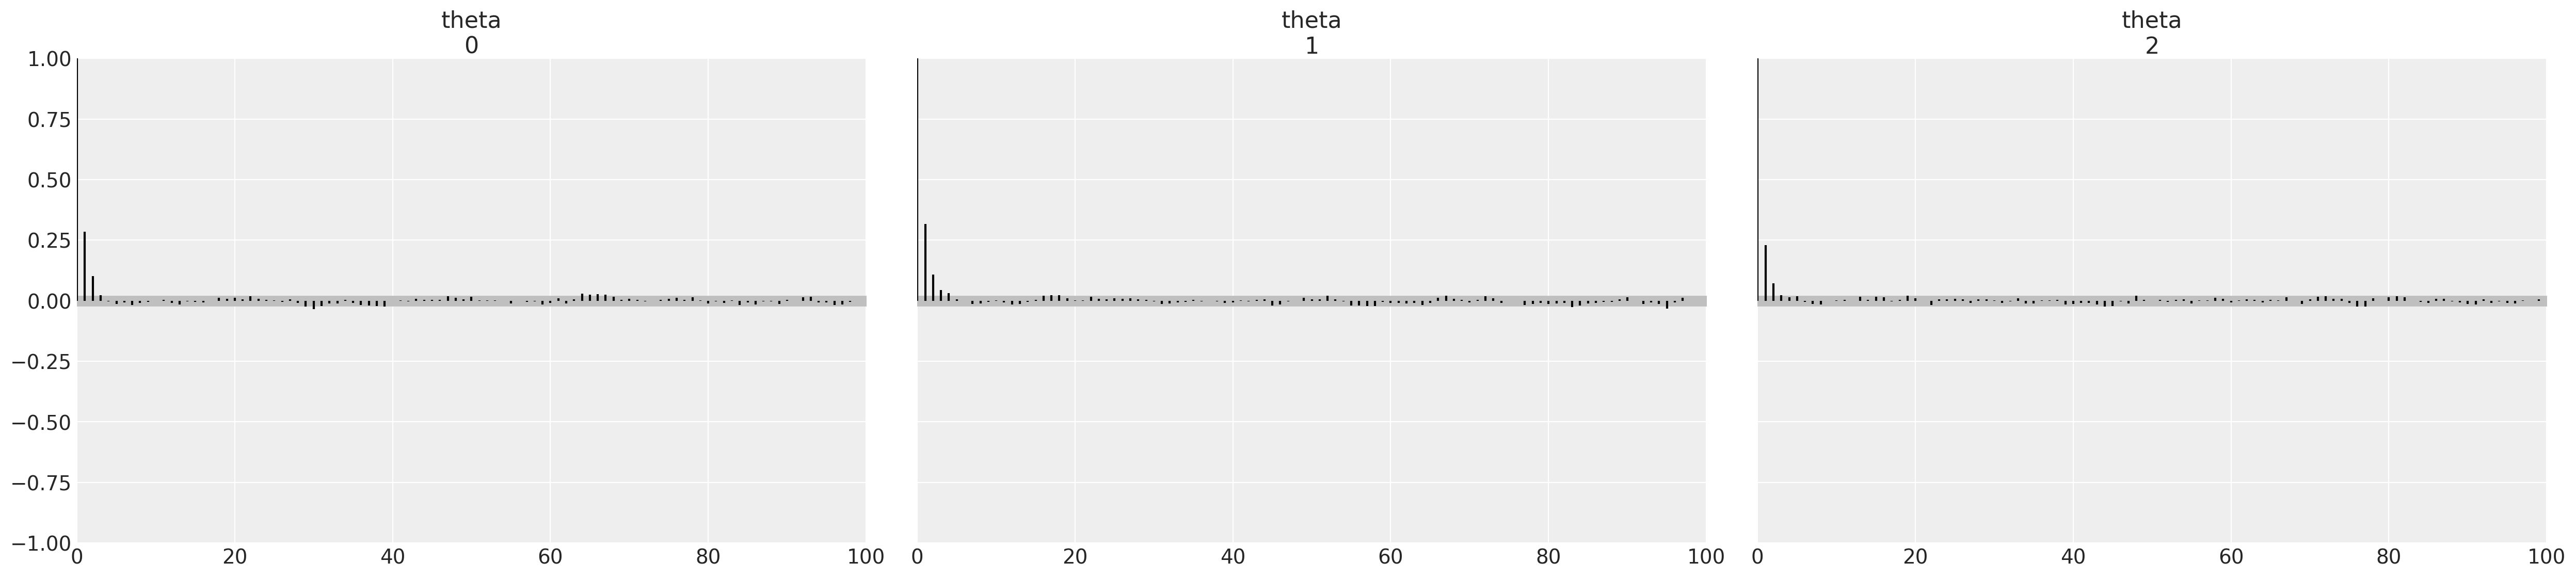

In [8]:
# Regardons l'autocorrélation sur chaque chaîne MCMC
with beta_binomial_model:
    az.plot_autocorr(trace,var_names=["theta"])

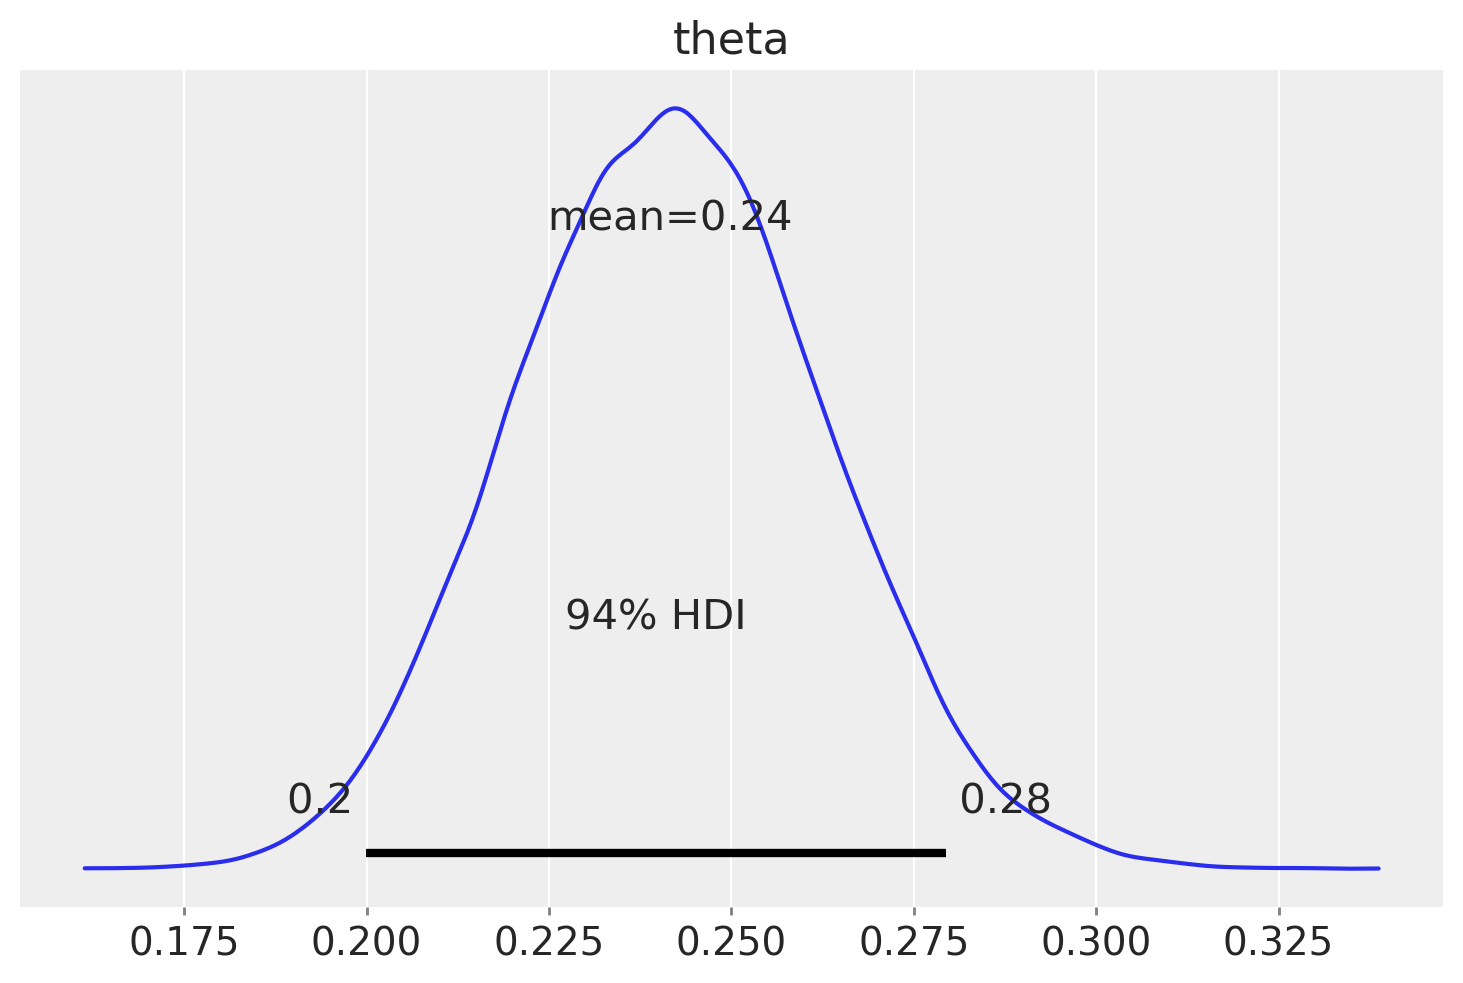

In [9]:
with beta_binomial_model: 
    # Traçons la loi a posteriori 
    az.plot_posterior(trace, var_names=["theta"])

In [10]:
# Estimons de nouveau la moyenne a posteriori
trace["theta"].mean(axis=0)

0.24160831235600622

/Users/nicolasbousquet/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c29f1fa50>],
      dtype=object)

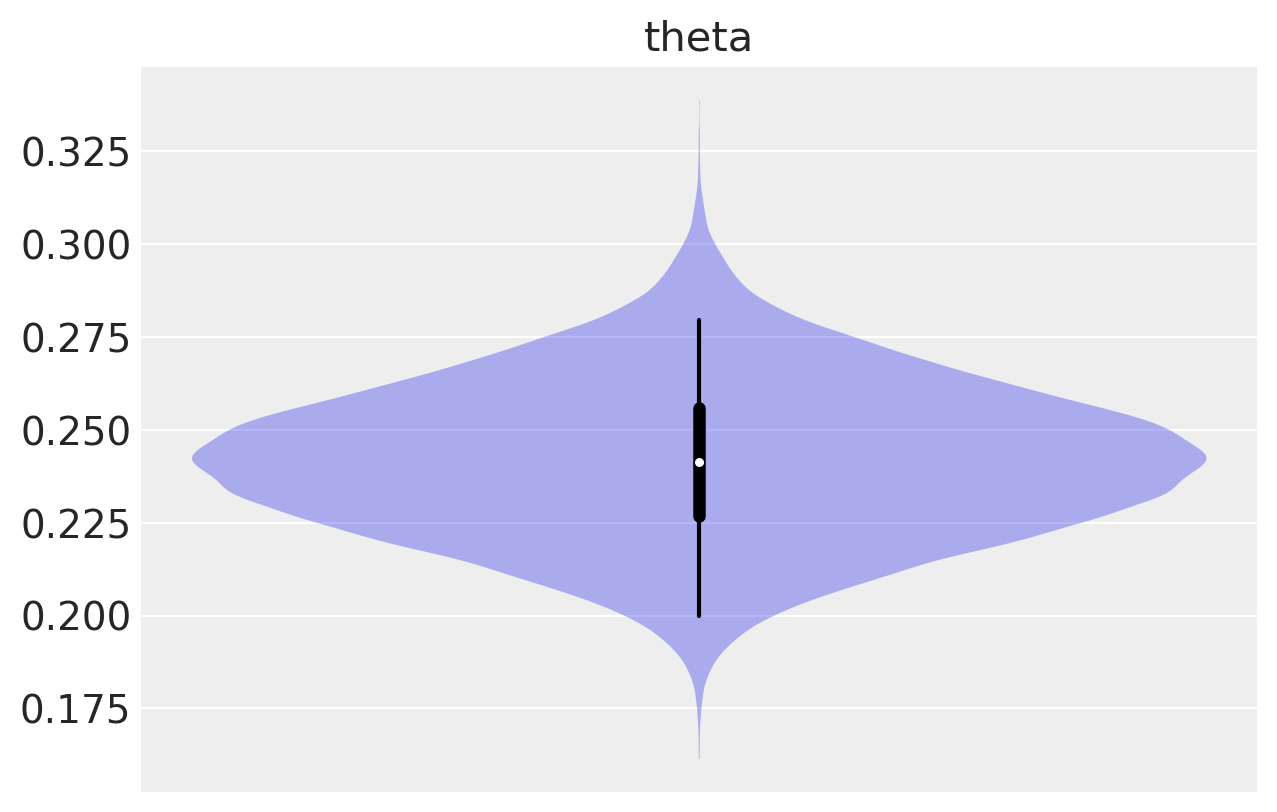

In [11]:
# On peut aussi faire un violin plot
az.plot_violin(trace, var_names=["theta"])

In [12]:
# On peut fournir un plus vaste ensemble de résultats
with beta_binomial_model:
    display(az.summary(trace, kind="stats"))

,mean,sd,hdi_3%,hdi_97%
a,0.990,0.769,0.012,2.360
theta,0.242,0.021,0.200,0.279


In [13]:
# On peut faire aussi le calcul du MAP (Maximum a Posteriori) à partir de la définition du modèle
# Ce calcul est fait par défaut par l'algorithme BFGS 
with beta_binomial_model:
    map_estimate = pm.find_MAP(model=beta_binomial_model,method="BFGS")
map_estimate

{'a_log__': array(-0.92312249),
 'theta_logodds__': array(-1.14012072),
 'a': array(0.39727661),
 'theta': array(0.2422982)}

In [ ]:
# Essayez de remplacer les choix a priori sur a et b en utilisant le concept de données virtuelles

In [26]:
# Calcul du critère WAIC
with beta_binomial_model:
    waic = az.waic(trace,beta_binomial_model)
waic

Computed from 30000 by 20 log-likelihood matrix

          Estimate       SE
elpd_waic   -40.62     2.45
p_waic        0.84        -

In [17]:
# Calcul du critère WAIC par Leave-One-Out
with beta_binomial_model:
    waic_loo = az.loo(trace,beta_binomial_model)
waic_loo

Computed from 30000 by 20 log-likelihood matrix

         Estimate       SE
elpd_loo   -40.62     2.45
p_loo        0.84        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%